# Practice Session 08: Communities

In [1]:
import io
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import statistics

# 1. The graph

In [3]:
INPUT_GRAPH_FILENAME = "data/starwars/starwars.graphml"
sw_in = nx.read_graphml(INPUT_GRAPH_FILENAME)
sw_relabeled = nx.relabel.relabel_nodes(sw_in, dict(sw_in.nodes(data='name')))
sw = sw_relabeled.to_undirected()

The following code, which you can leave as-is or modify for better visualization, displays a graph. It also accepts a ``partition`` argument, which we will use later on.

In [4]:
def plot_graph(g, width=20, height=20, font_size=12, partition=None):

    # Create a plot of width x height
    plt.figure(figsize=(width, height))

    # By default the partition is going to be all nodes in the same partition
    if partition is None:
        partition = [ set(g.nodes()) ]

    # Number of partitions
    num_parts = len(partition)

    # Create a map from nodes to color using color values from 0.0 for the first partition
    # to 1-1/P for the last partition, assuming there are P partitions
    node_to_color = {}
    part_color = 0.0
    for part in partition:
        for node in part:
            node_to_color[node] = part_color
        part_color += 1.0/num_parts

    # Create a list of colors in the ordering of the nodes
    colors = [node_to_color[node] for node in g.nodes()]

    # Layout the nodes using a spring model
    nx.draw_spring(g, with_labels=True, node_size=1000, font_size=font_size,
                   cmap=plt.get_cmap('YlOrRd'), node_color=colors)

    # Display
    plt.show()

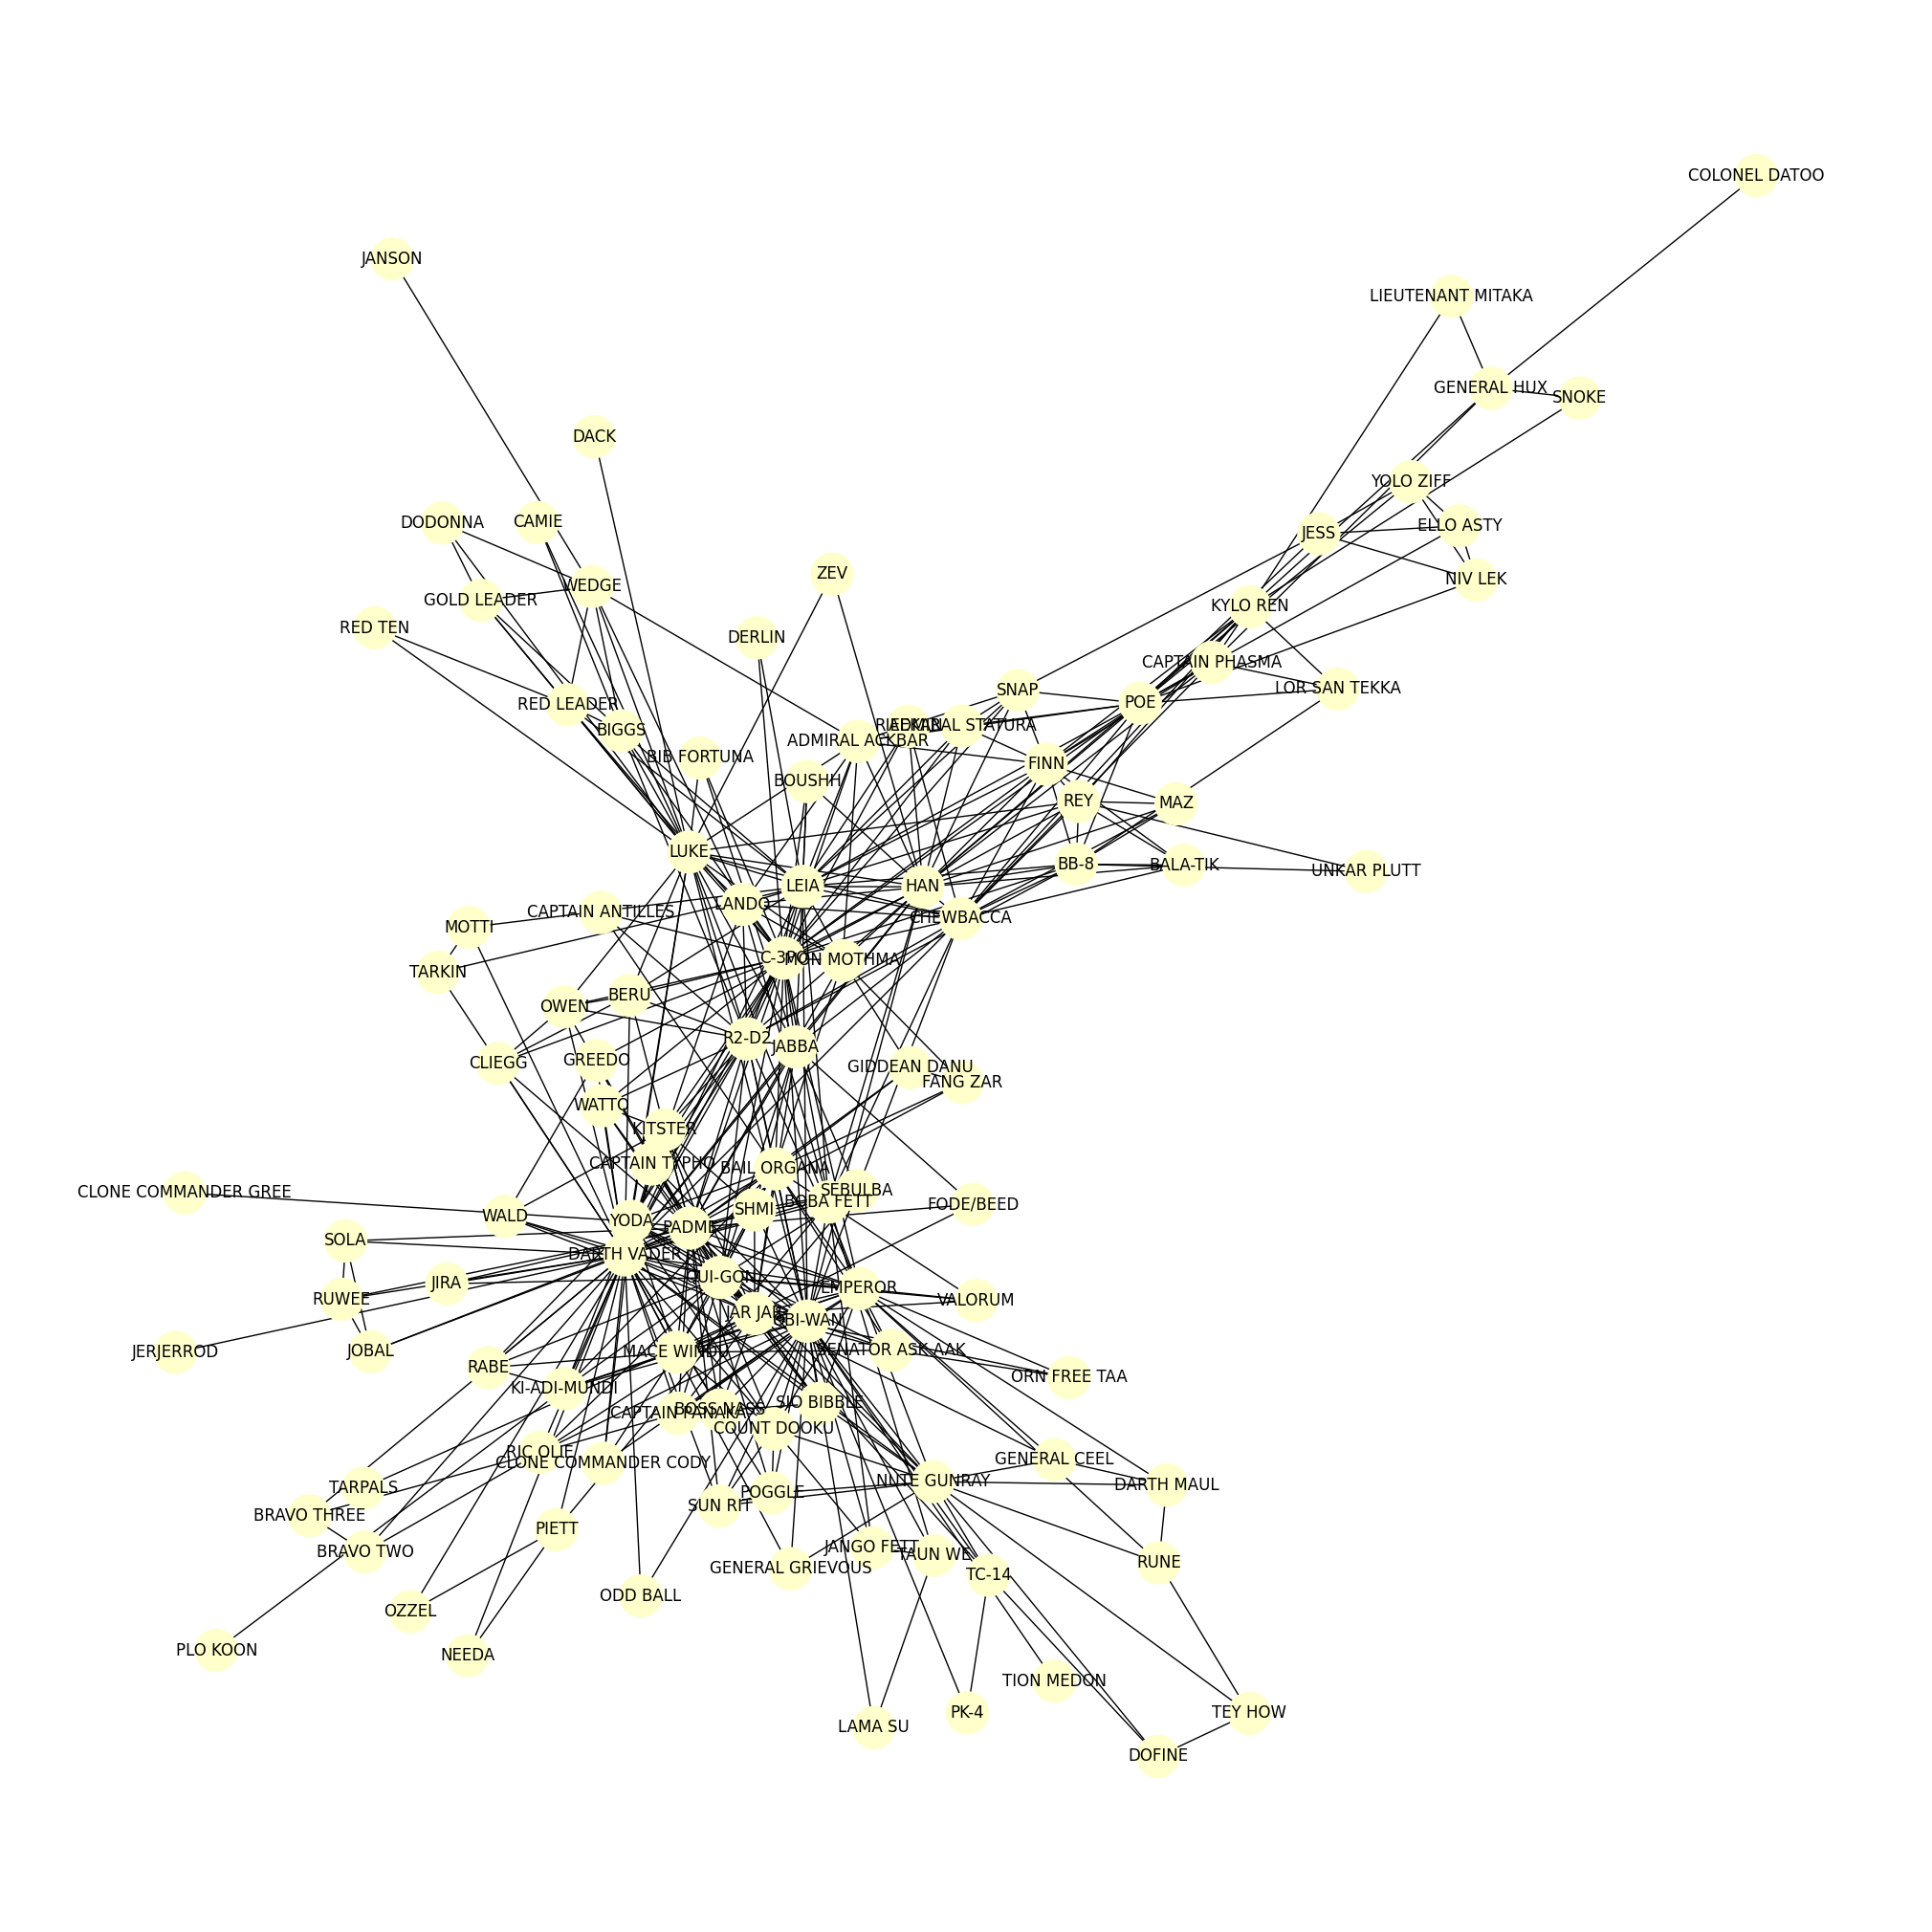

In [6]:
plot_graph(sw)

# 2. K-core decomposition

In [7]:
def get_max_degree(g):
    degree_sequence = [x[1] for x in g.degree()]
    return(max(degree_sequence))


def nodes_with_degree_less_or_equal_than(g, degree):
    nodes = []
    for node in g.nodes():
        if g.degree(node) <= degree:
            nodes.append(node)
    return nodes

In [8]:
def kcore_decomposition(g):
    node_to_kcore_number = {}
    g_copy = g.copy()
    max_degree = get_max_degree(g_copy)
    for k in range(0, max_degree+1):
        nodes_to_remove = nodes_with_degree_less_or_equal_than(g_copy, k)
        while len(nodes_to_remove) > 0:
            for node in nodes_to_remove:
                node_to_kcore_number[node] = k
                g_copy.remove_node(node)
            nodes_to_remove = nodes_with_degree_less_or_equal_than(g_copy, k)
    for node in g_copy.nodes():
        node_to_kcore_number[node] = max_degree
    return node_to_kcore_number

In [9]:
node_to_kcore = kcore_decomposition(sw)

for character in ["LEIA", "C-3PO", "REY", "TARKIN"]:
    print("K-core of {:s}: {:d}".format(character, node_to_kcore[character]))

K-core of LEIA: 7
K-core of C-3PO: 8
K-core of REY: 6
K-core of TARKIN: 3


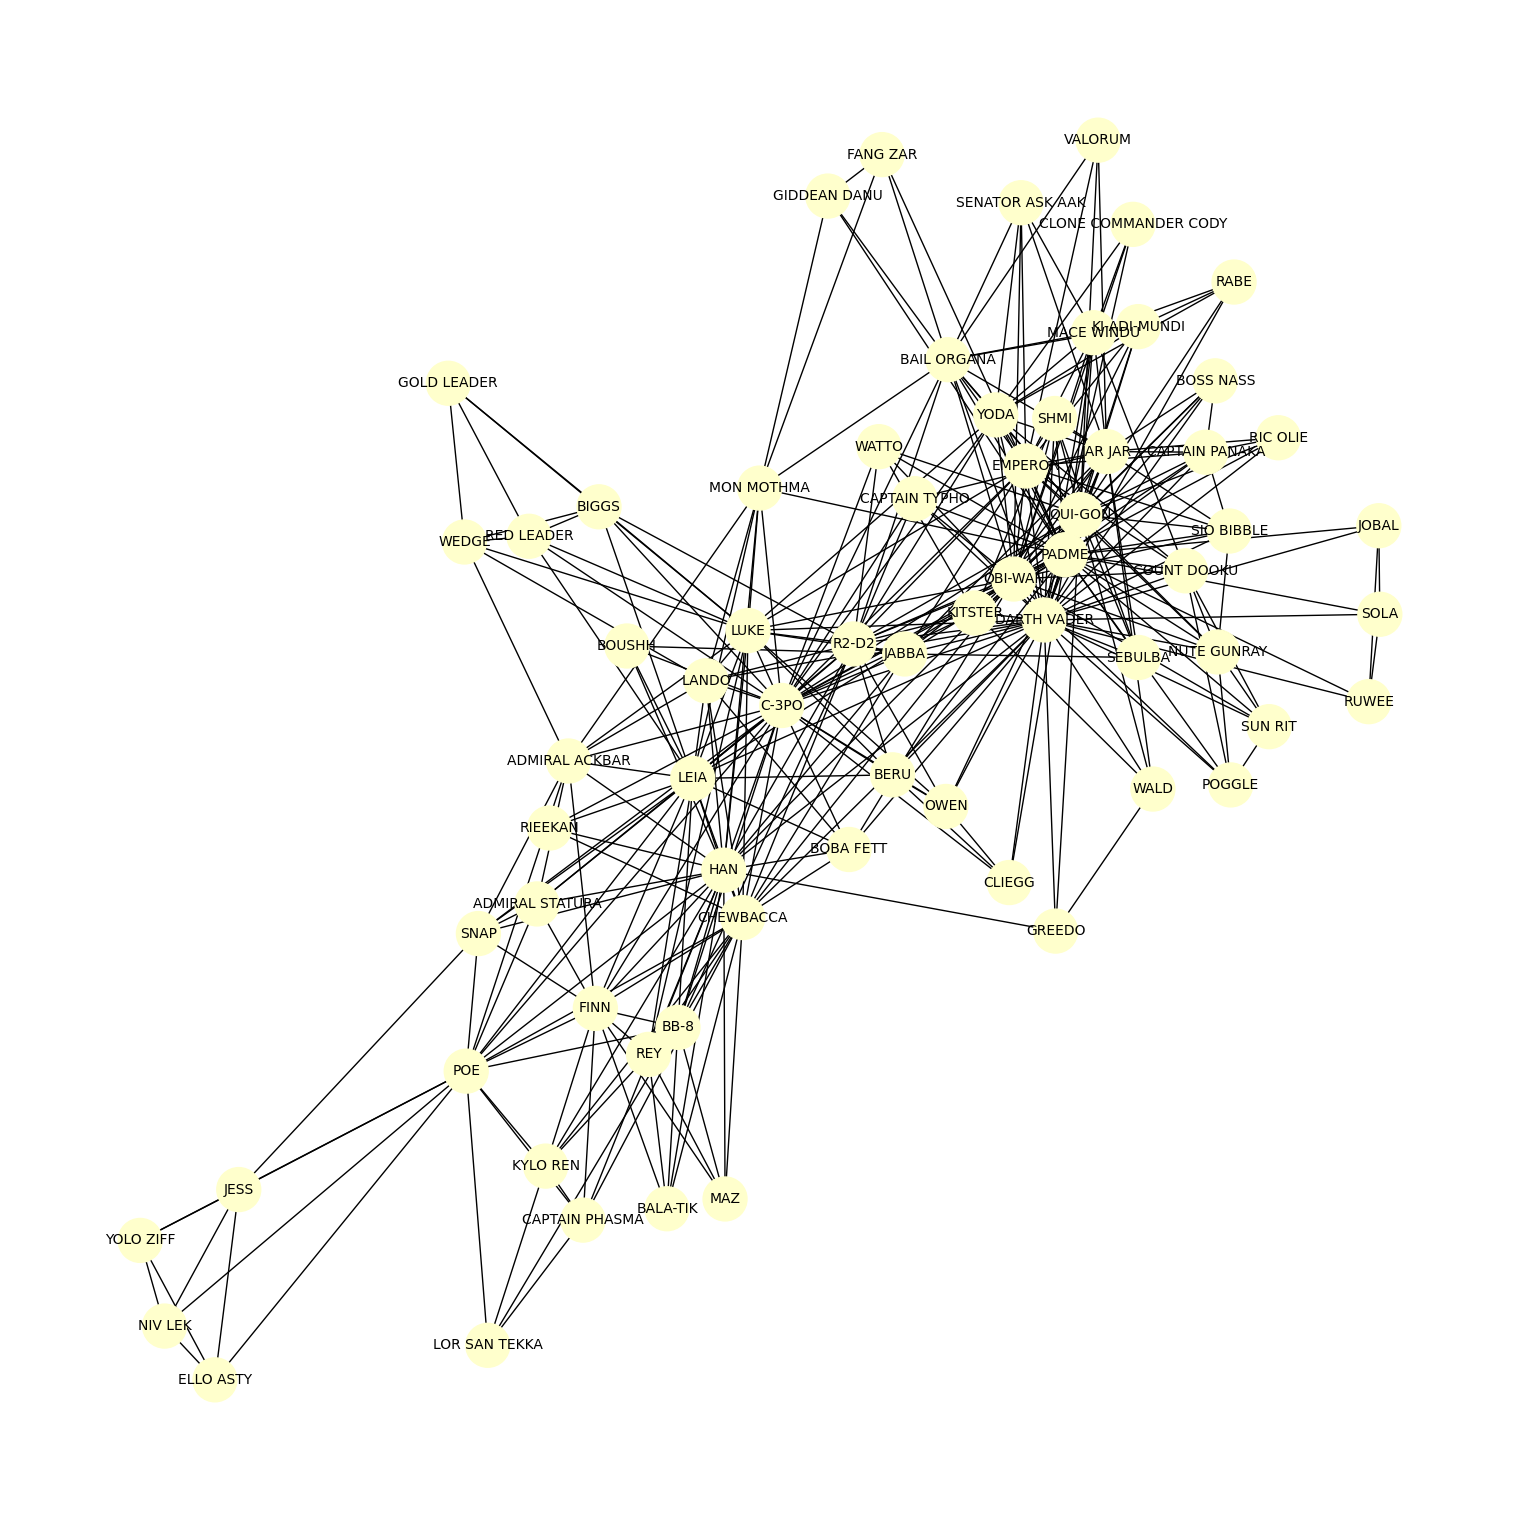

In [10]:
def create_kcores_subgraph(g,k):
    nodes_in_kcore = [node for node in g.nodes() if node_to_kcore[node] >= k] # check if node's k-core number is at least 4 and add them to the list nodes_in_kcore
    return g.subgraph(nodes_in_kcore) # return the subraph containing only the nodes in nodes_in_kcore

swcore = create_kcores_subgraph(sw, 4) # execute the function creating the 4-core subgraph
plot_graph(swcore, width=15, height=15, font_size=10) # plot the 4-core subgraph

# 3. Modularity of a partition

We will compute the modularity of a partitioning. First, let's draw a small toy graph.

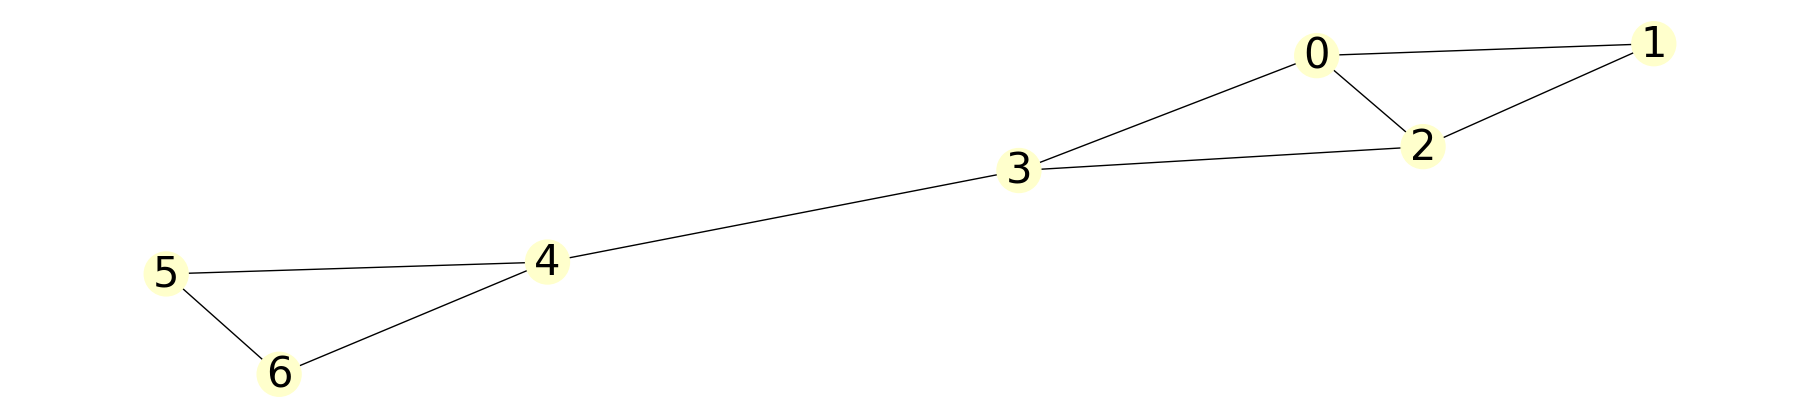

In [11]:
g = nx.Graph()

g.add_edge(0, 1)
g.add_edge(1, 2)
g.add_edge(2, 3)
g.add_edge(3, 0)
g.add_edge(0, 2)
g.add_edge(3, 4)
g.add_edge(4, 5)
g.add_edge(5, 6)
g.add_edge(6, 4)

# NOTE: for each run, the visualization will be different, but the graph should have the connections indicated above
plot_graph(g, height=4, width=18, font_size=30)

A partition of a graph is represented as a list of sets. Each set represents a part of the graph. For instance, the following are two partitions. The first one is arguably the most natural way of dividing this graph: nodes 0, 1, 2, 3 belong to one partition, and nodes 4, 5, and 6 to the other partition. The second one places the node 3 in the "wrong" partition.

NetworkX has a function to compute the modularity of a partition: [community.quality.modularity](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html). It applies the formula we discussed in class:

$$
Q = \frac{1}{L} \sum_{C} \left( L_C - \frac{k_C^2}{4L} \right)
$$

Where:

* Q is the modularity
* C is a community
* $L_{C}$ is the number of internal links in C (internal means connecting two nodes in C)
* $K_{C}$ is the summation of the degree of nodes in C
* L is the total number of links in the graph

Remember that in modularity, the greater it is the better partitioned it is.


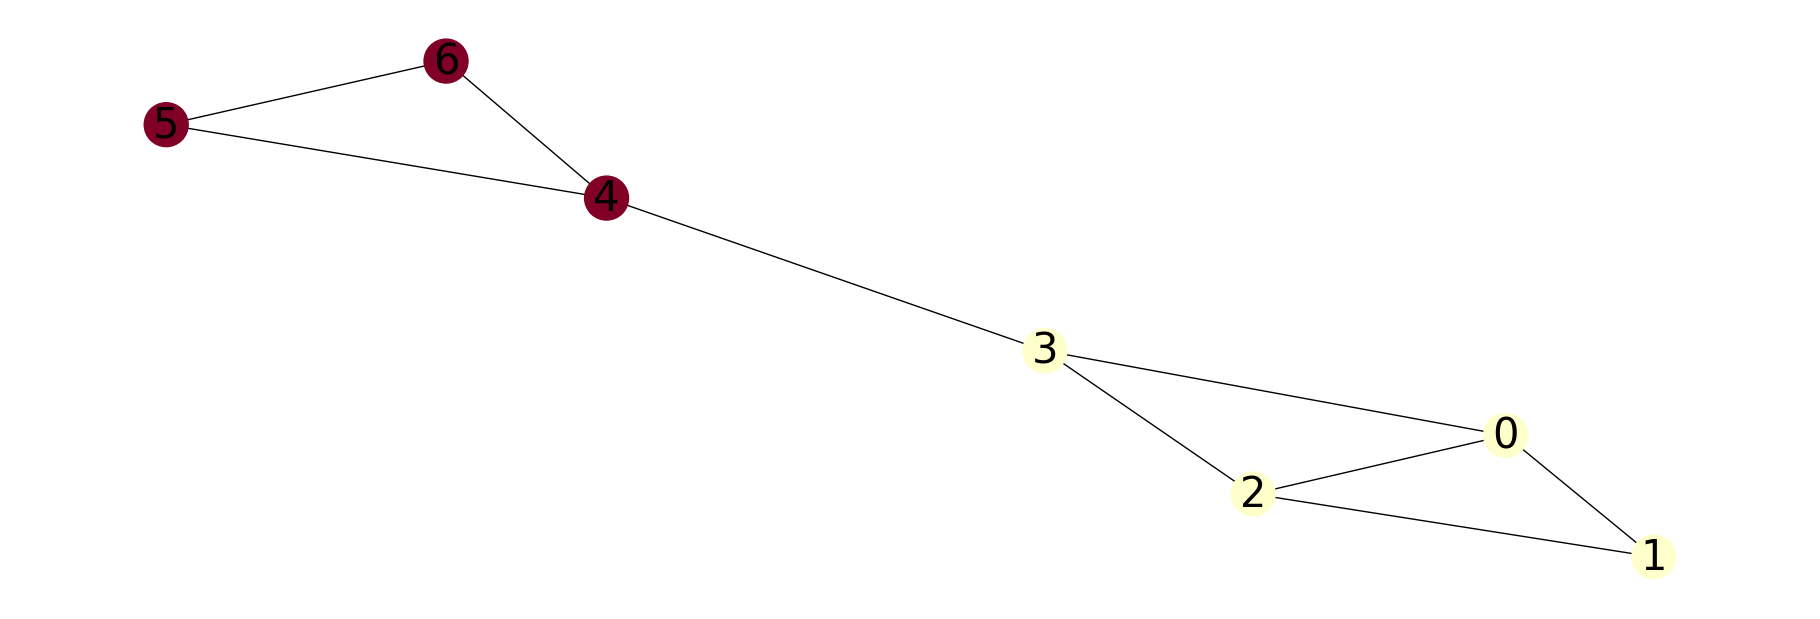

Modularity of partition 1 according to NetworkX: 0.3642


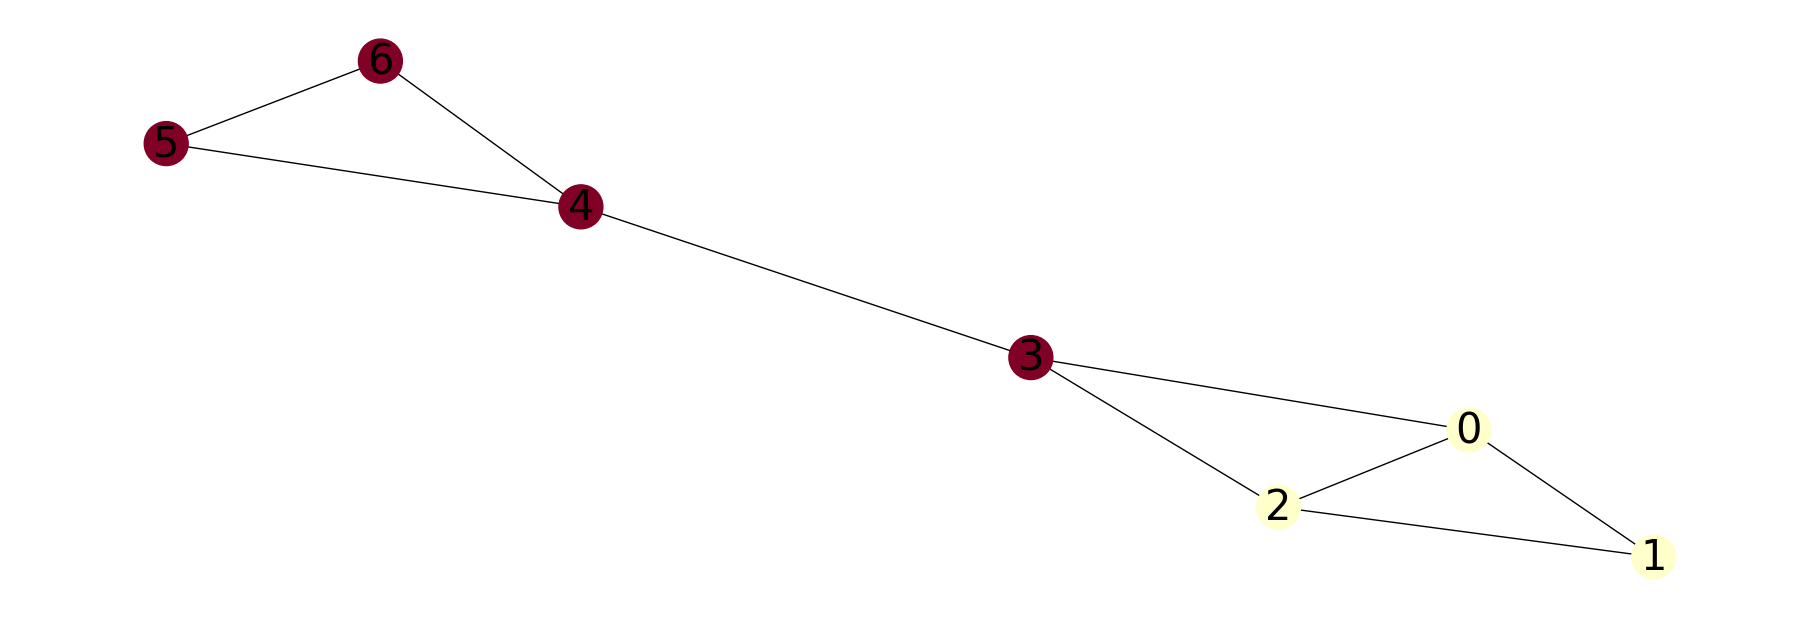

Modularity of partition 2 according to NetworkX: 0.2716


In [12]:
partition1 = [
    {0, 1, 2, 3},
    {4, 5, 6}
]
plot_graph(g, height=6, width=18, font_size=30, partition=partition1)
print("Modularity of partition 1 according to NetworkX: %.4f" % nx.community.quality.modularity(g, partition1))


partition2 = [
    {0, 1, 2},
    {3, 4, 5, 6}
]
plot_graph(g, height=6, width=18, font_size=30, partition=partition2)
print("Modularity of partition 2 according to NetworkX: %.4f" % nx.community.quality.modularity(g, partition2))

In [13]:
def Lc(g, C):
    Lc = 0
    for u in C:
        for v in C:
            if g.has_edge(u,v):
                Lc += 1
    Lc = Lc / 2  # each edge counted twice
    return Lc

def kc(g, C):
    kc = 0
    for u in C:
        kc += g.degree(u)
    return kc


def modularity(g, partition):
    m = g.number_of_edges()
    Q = 0.0
    for part in partition:
        for u in part:
            for v in part:
                A_uv = 1 if g.has_edge(u,v) else 0
                k_u = g.degree(u)
                k_v = g.degree(v)
                Q += A_uv - (k_u * k_v) / (2*m)
    Q = Q / (2*m)
    return Q

Use the following to test your code.

In [14]:
print("Modularity of partition 1: mine={:.6f}, networkx={:.6f}".format(
    modularity(g, partition1), nx.community.quality.modularity(g, partition1)))

print("Modularity of partition 2: mine={:.6f}, networkx={:.6f}".format(
    modularity(g, partition2), nx.community.quality.modularity(g, partition2)))


Modularity of partition 1: mine=0.364198, networkx=0.364198
Modularity of partition 2: mine=0.271605, networkx=0.271605


# 4. Girvan-Newman algorithm

In [15]:
def largest_betweenness_edge(g):
    betweenness = nx.edge_betweenness_centrality(g)

    # get edge with the highest betweenness
    max_edge = max(betweenness, key=betweenness.get)

    # if key is a triple like (u, v, 0), return only (u, v)
    if len(max_edge) == 3:
        return (max_edge[0], max_edge[1])
    else:
        return max_edge


In [16]:
def list_connected_components(g):
    return list(nx.connected_components(g))

def number_connected_components(g):
    return len(list_connected_components(g))


In [17]:
def girvan_newman(g):
    # make copy so the original graph isnt modified
    g = g.copy()
    
    # start with one component: all nodes
    partitions = [ [set(g.nodes())] ]
    
    # continue till node is its own component
    while len(partitions[-1]) < g.number_of_nodes():
        
        edge_to_remove = largest_betweenness_edge(g)
        g.remove_edge(*edge_to_remove)
        current_components = [set(c) for c in nx.connected_components(g)]

        # if number of components increased, append
        if len(current_components) > len(partitions[-1]):
            partitions.append(current_components)
    
    return partitions


In [18]:
def run_girvan_newman(g, graph_name="Graph"):

    partitions = girvan_newman(g)
    modularity_profile = []
    i = 1
    for partition in partitions:
        print("Number of partitions=" + str(i))
        print("Partition %s" % (partition,))
        m = modularity(g, partition)
        print("Modularity: %.4f" % m)
        modularity_profile.append(m)
        print()
        i += 1

    # Correct x-axis for plotting
    x = np.arange(1, len(modularity_profile) + 1)

    # Adjust point size inversely to number of points
    point_size = max(20, 200 / len(modularity_profile))

    plt.xlabel("Partition nº")
    plt.ylabel("Modularity")
    plt.title("Modularity profile")
    plt.scatter(x, modularity_profile, s=point_size, label=graph_name)
    plt.legend()


Number of partitions=1
Partition [{0, 1, 2, 3, 4, 5, 6}]
Modularity: 0.0000

Number of partitions=2
Partition [{0, 1, 2, 3}, {4, 5, 6}]
Modularity: 0.3642

Number of partitions=3
Partition [{0, 2, 3}, {1}, {4, 5, 6}]
Modularity: 0.2531

Number of partitions=4
Partition [{0}, {1}, {2, 3}, {4, 5, 6}]
Modularity: 0.1420

Number of partitions=5
Partition [{0}, {1}, {2}, {3}, {4, 5, 6}]
Modularity: 0.0864

Number of partitions=6
Partition [{0}, {1}, {2}, {3}, {4}, {5, 6}]
Modularity: -0.0617

Number of partitions=7
Partition [{0}, {1}, {2}, {3}, {4}, {5}, {6}]
Modularity: -0.1481



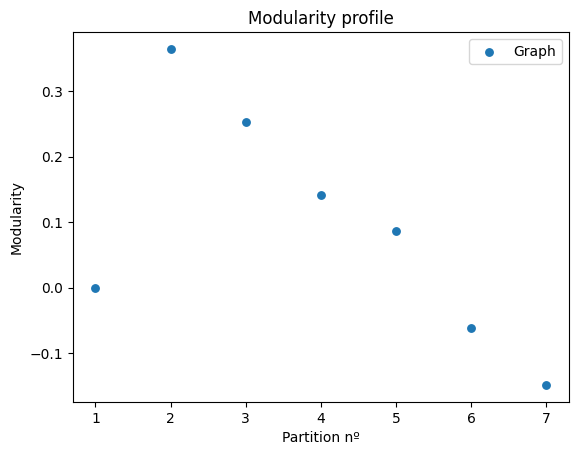

In [19]:
run_girvan_newman(g)

Number of partitions=1
Partition [{'BB-8', 'BOUSHH', 'FINN', 'KI-ADI-MUNDI', 'CAPTAIN TYPHO', 'DARTH VADER', 'ORN FREE TAA', 'BERU', 'TARKIN', 'DODONNA', 'BALA-TIK', 'MAZ', 'KITSTER', 'OBI-WAN', 'CLONE COMMANDER GREE', 'CAMIE', 'CAPTAIN ANTILLES', 'BIGGS', 'RUWEE', 'GENERAL CEEL', 'TAUN WE', 'WEDGE', 'JESS', 'SNAP', 'CLIEGG', 'SENATOR ASK AAK', 'JOBAL', 'ADMIRAL STATURA', 'JANSON', 'POE', 'DARTH MAUL', 'LAMA SU', 'CHEWBACCA', 'DERLIN', 'MOTTI', 'LUKE', 'BOBA FETT', 'TARPALS', 'RUNE', 'RIEEKAN', 'ZEV', 'GIDDEAN DANU', 'GREEDO', 'C-3PO', 'ADMIRAL ACKBAR', 'MACE WINDU', 'BIB FORTUNA', 'REY', 'HAN', 'FANG ZAR', 'SIO BIBBLE', 'TC-14', 'NUTE GUNRAY', 'BRAVO TWO', 'JANGO FETT', 'UNKAR PLUTT', 'ELLO ASTY', 'LOR SAN TEKKA', 'POGGLE', 'WATTO', 'BAIL ORGANA', 'RABE', 'R2-D2', 'ODD BALL', 'LEIA', 'BRAVO THREE', 'CLONE COMMANDER CODY', 'QUI-GON', 'NEEDA', 'RED LEADER', 'RIC OLIE', 'CAPTAIN PANAKA', 'TION MEDON', 'BOSS NASS', 'COUNT DOOKU', 'VALORUM', 'JERJERROD', 'GOLD LEADER', 'TEY HOW', 'COLONEL 

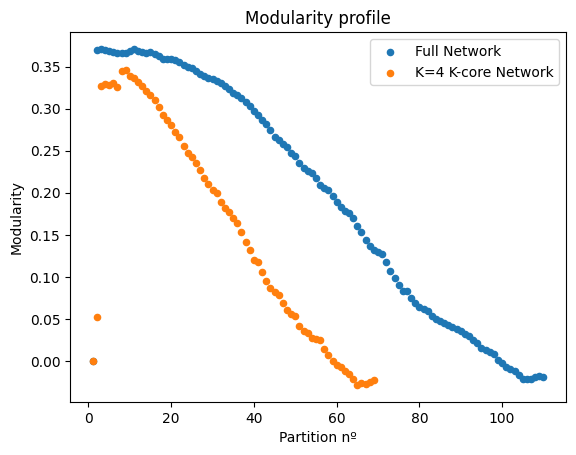

In [20]:
run_girvan_newman(sw,"Full Network")
run_girvan_newman(swcore, "K=4 K-core Network")

In general, as we increase the number of partitions the modularity decreases, which makes sense. It decreases linearly for the middle range of partition amount.
For the full network the highest modularity occurs at 3 partitions and for the 4-core it occurs at 9 partitions. This makes sense because the 4 core is a smaller denser network that is better split into smaller denser communities rather than big ones. 


Create function `run_girvan_newman_modularity` that runs Girvan-Newman and returns the partition with the largest modularity.

In [21]:
def run_girvan_newman_modularity(G):

    best_mod = float('-inf')
    best_partition = None

    # Girvan–Newman returns a generator of partitions with increasing number of communities
    for partition in girvan_newman(G):
        # Convert tuple-of-sets → list-of-sets (optional)
        communities = [set(c) for c in partition]

        # Compute modularity of this partition
        mod = modularity(G, communities)

        # Track the best one
        if mod > best_mod:
            best_mod = mod
            best_partition = communities

    return best_partition, best_mod

partitions, max_mod = run_girvan_newman_modularity(sw)
print("Full network:")
print("Max modularity:", max_mod)
print("Number of partitions:", len(partitions))

partitions_k4, max_mod_k4 = run_girvan_newman_modularity(swcore)
print("k=4 network:")
print("Max modularity:", max_mod_k4)
print("Number of partitions:", len(partitions_k4))



Full network:
Max modularity: 0.3710864580797027
Number of partitions: 3
k=4 network:
Max modularity: 0.3462207539340545
Number of partitions: 9


The following cell runs this over the entire graph and its corresponding k-core 4.

The best partition has modularity 0.3711 and 3 communities


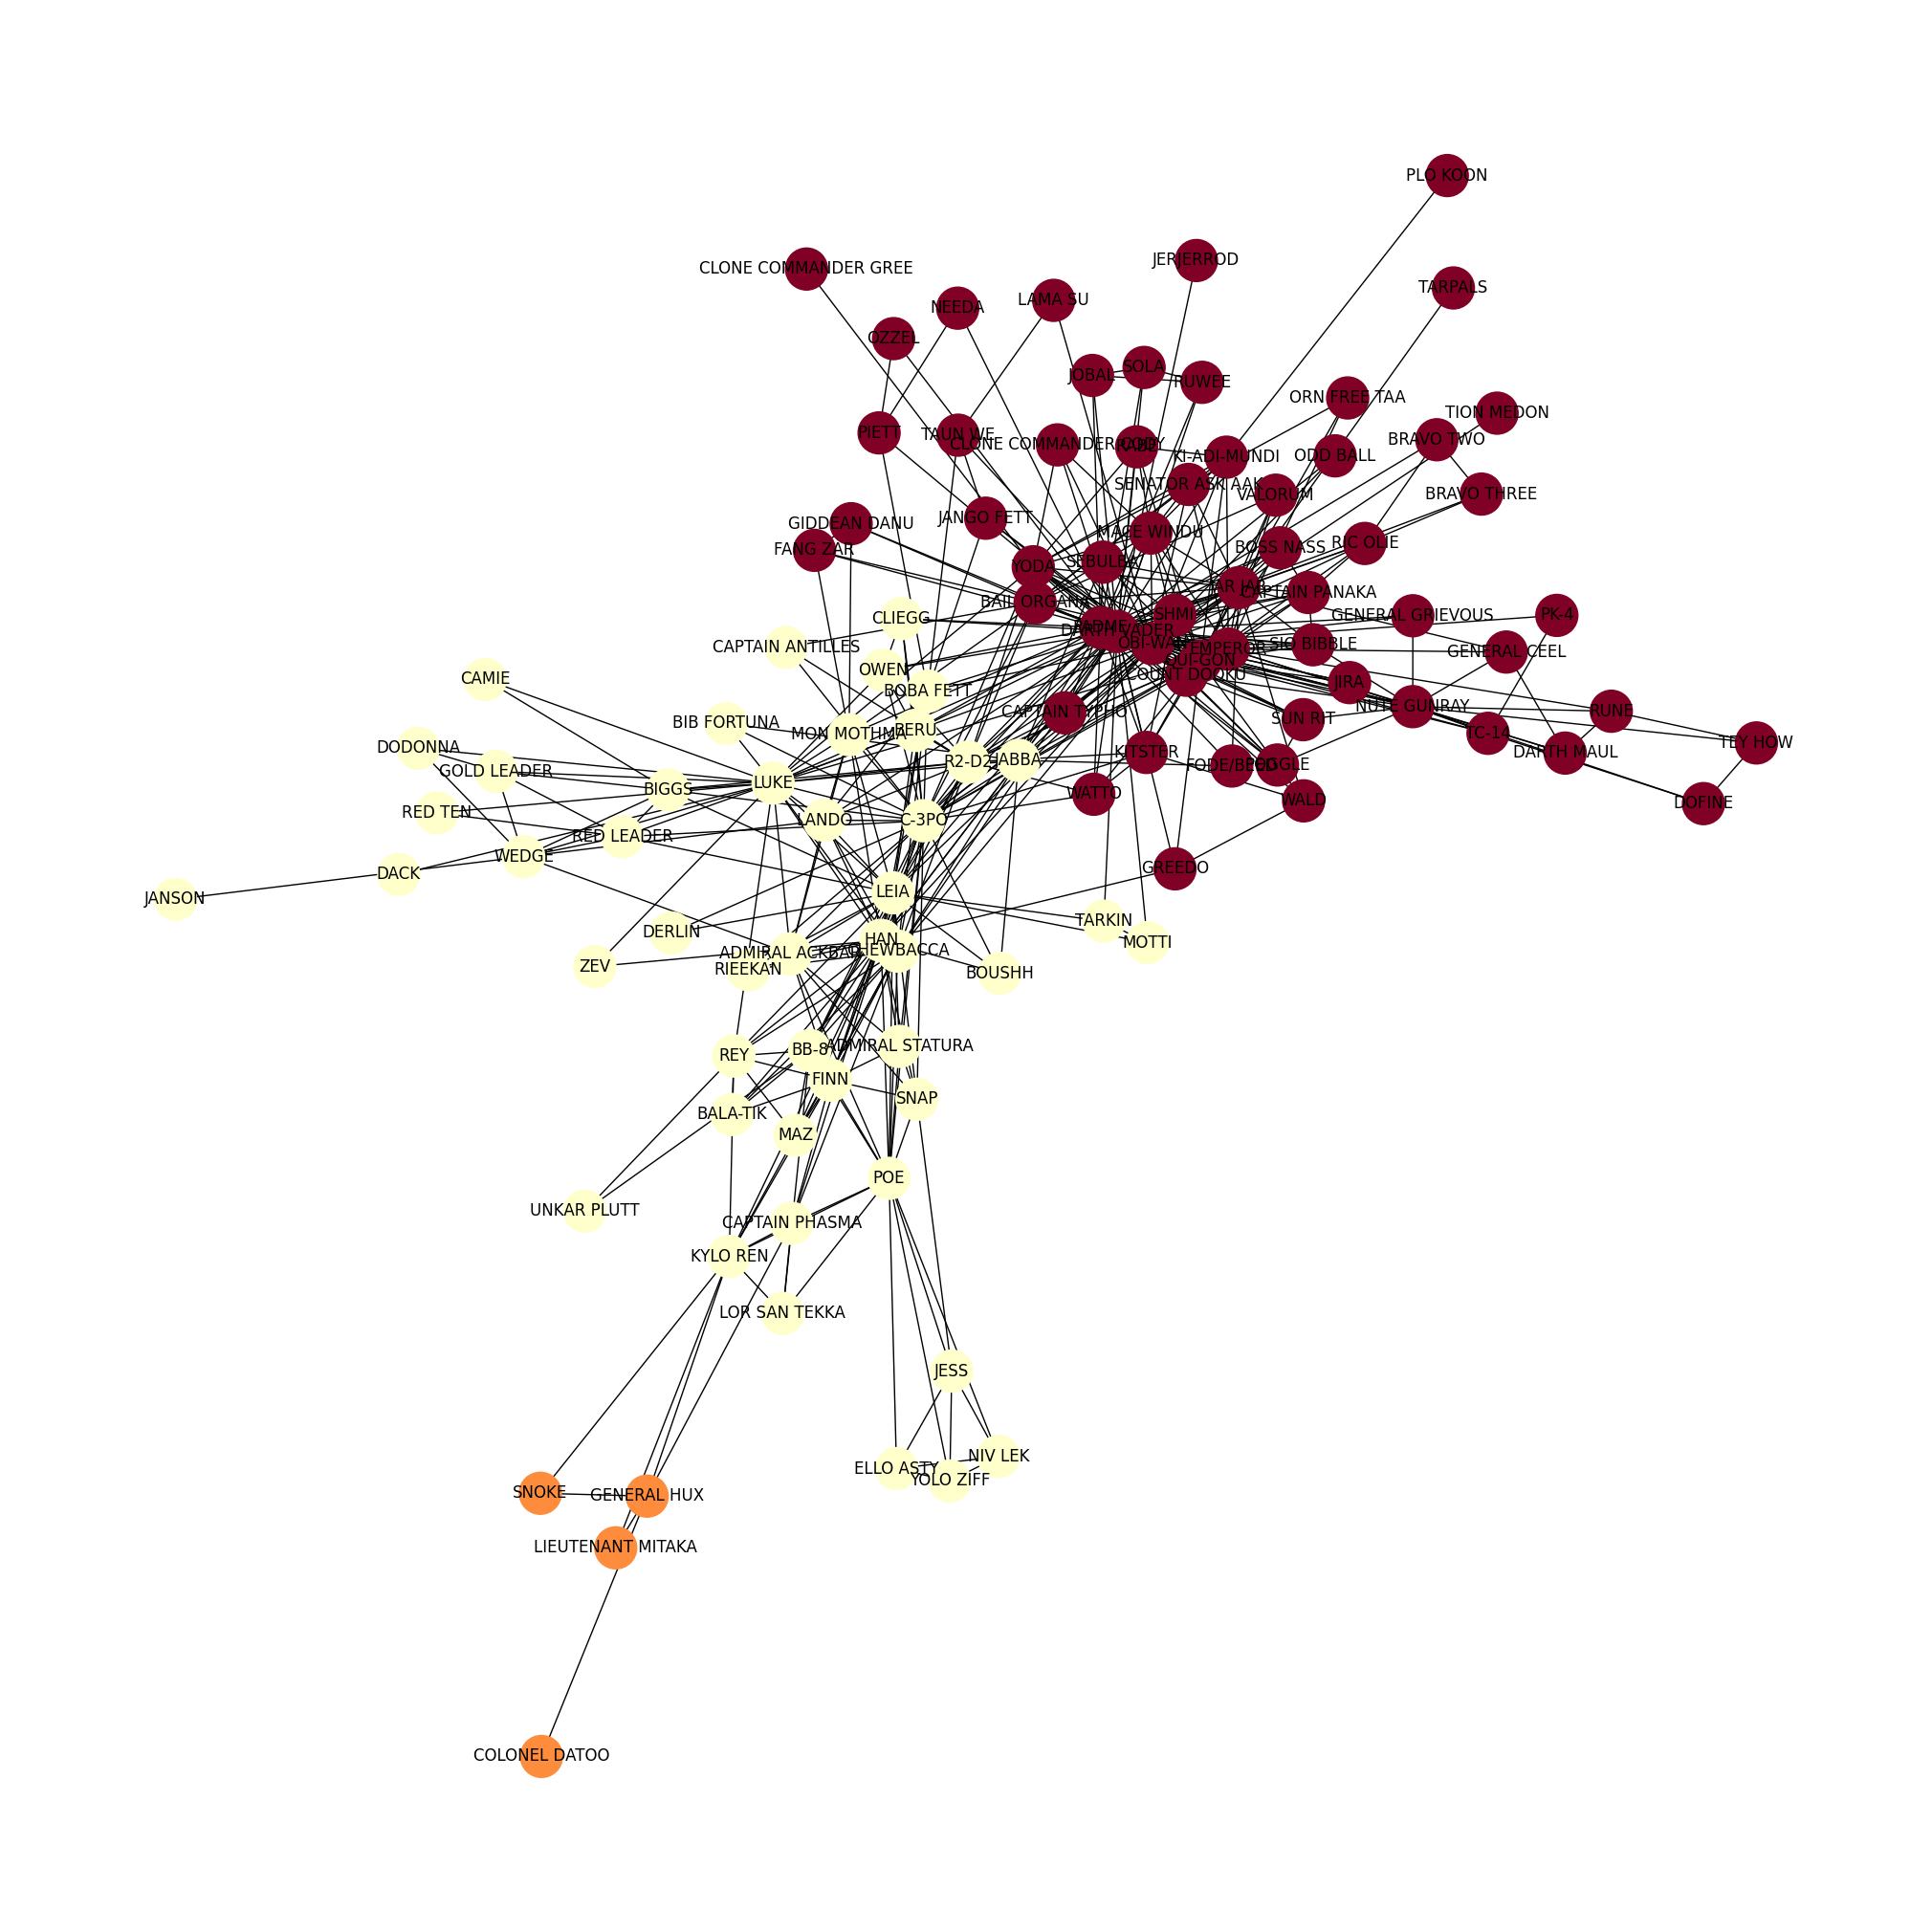

The best partition has modularity 0.3462 and 9 communities


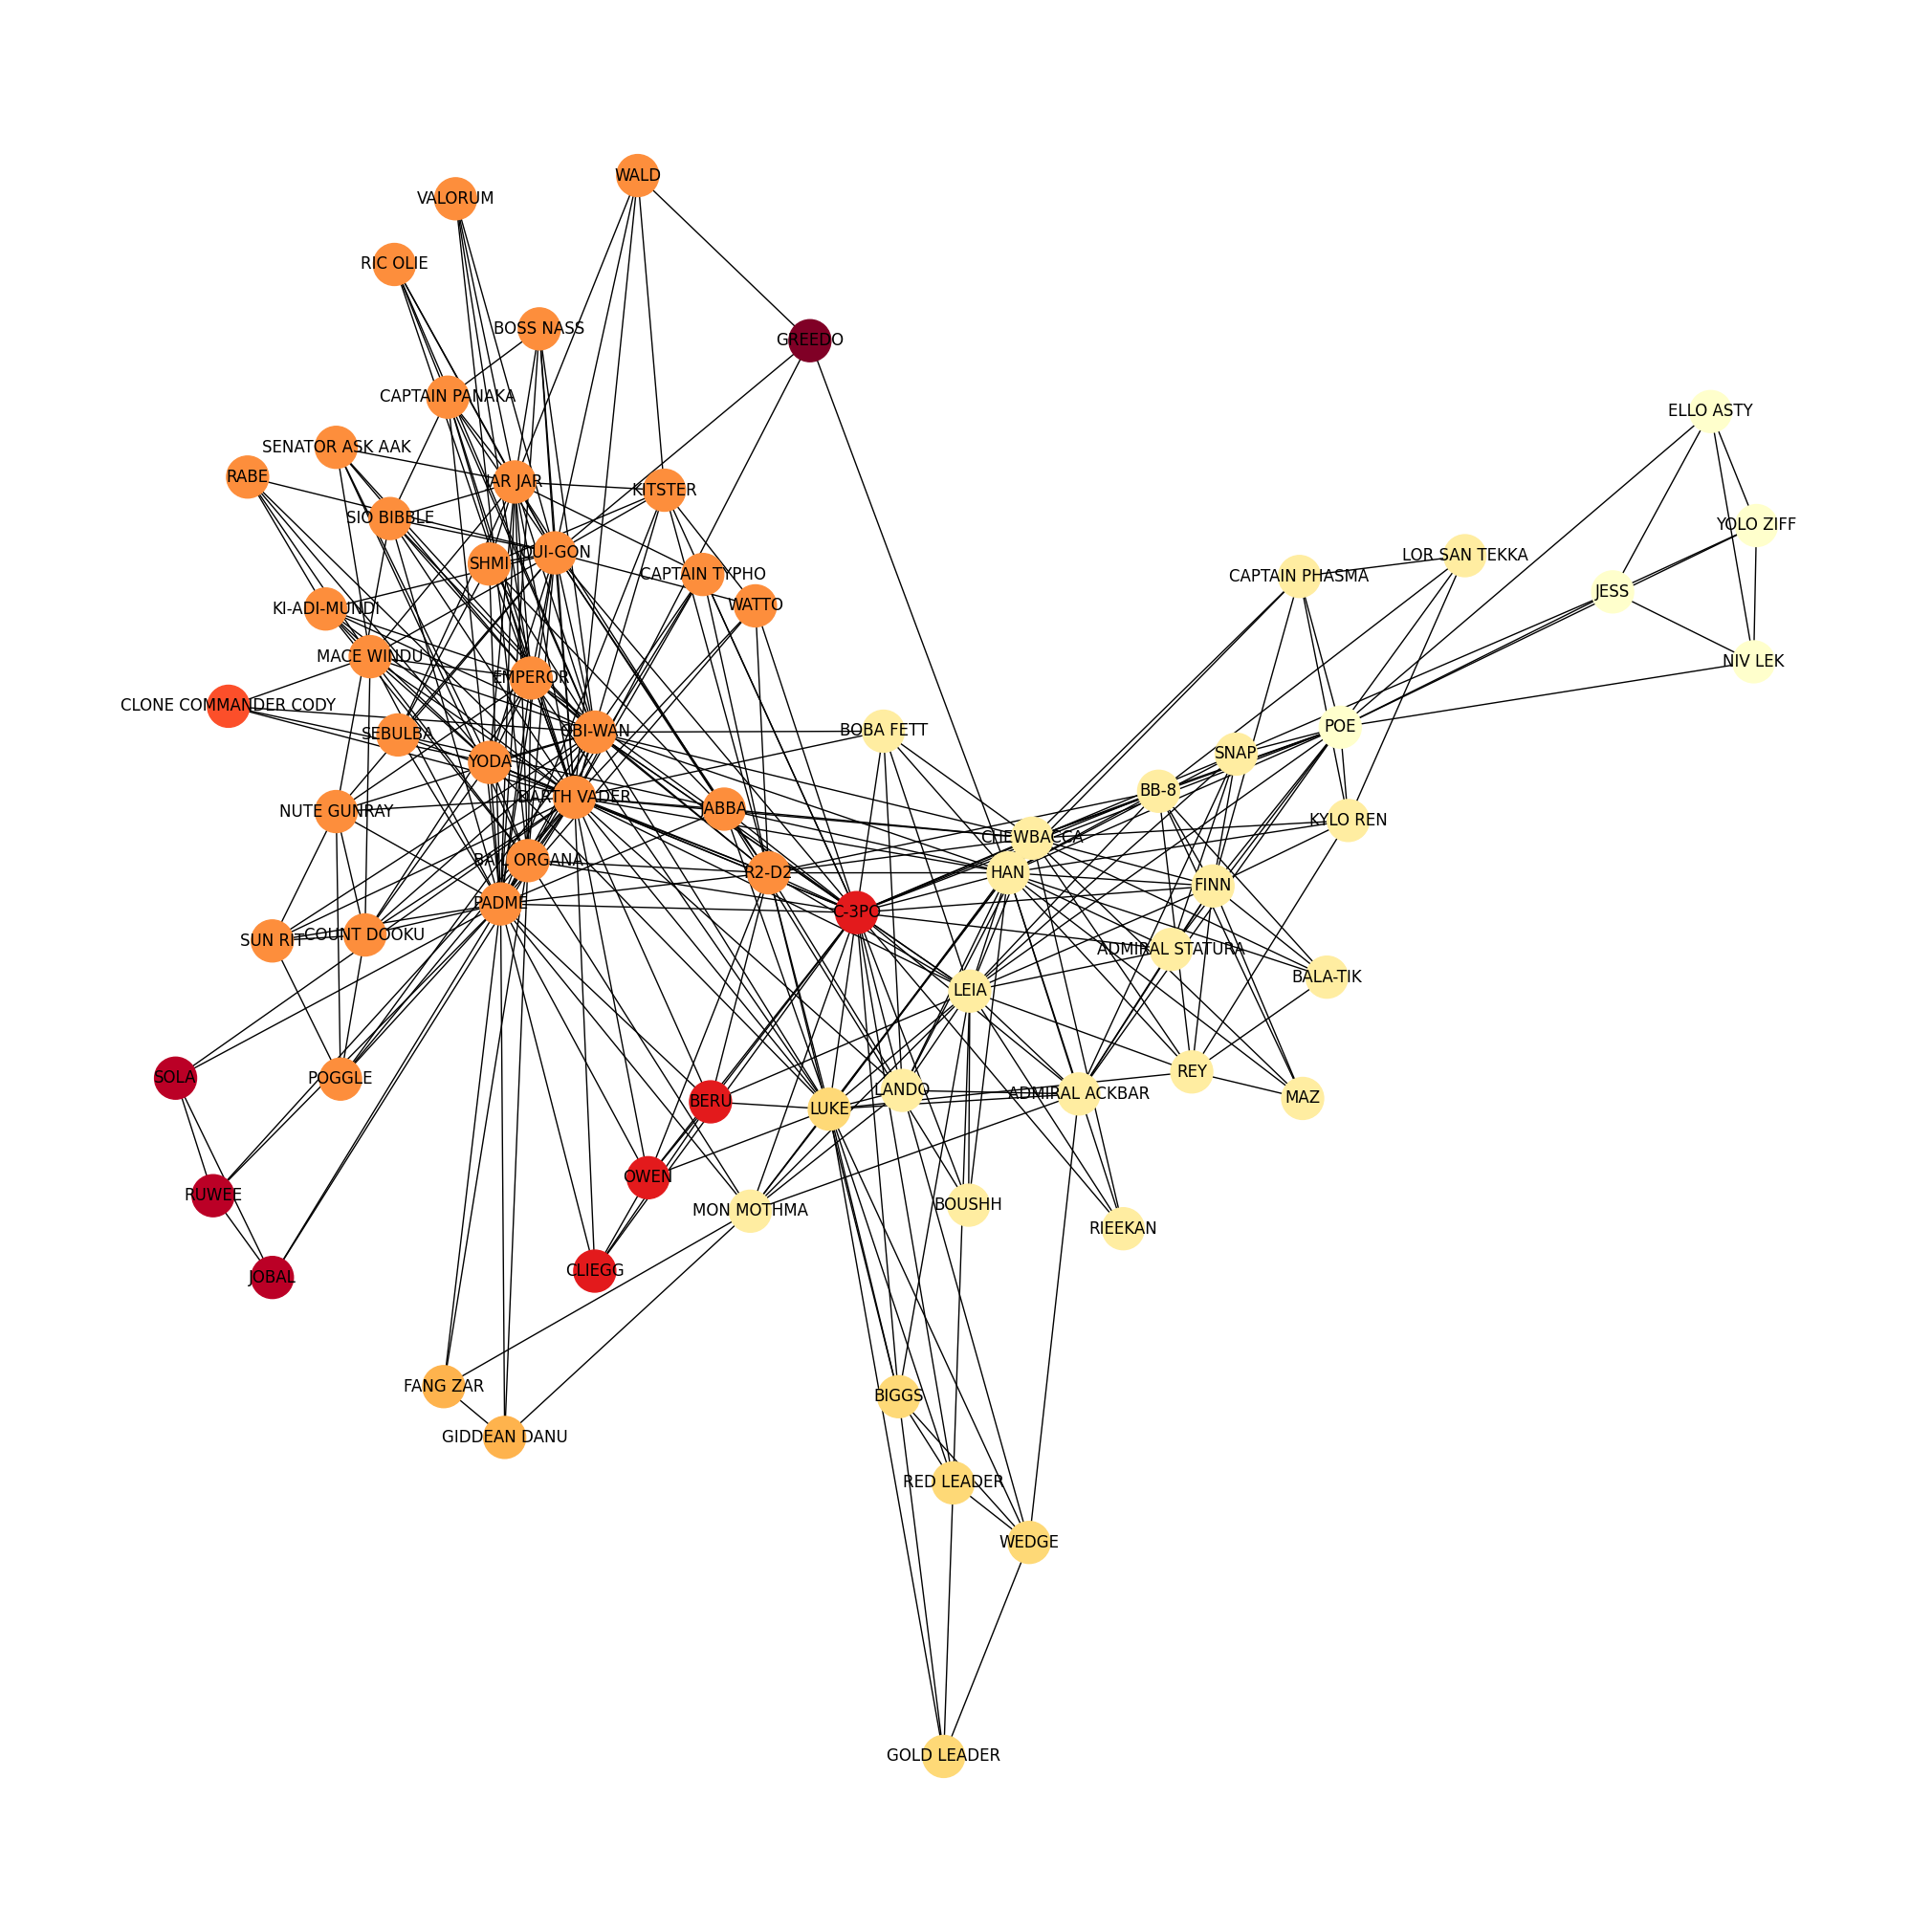

In [22]:
partition_tuple = run_girvan_newman_modularity(sw)
partition = partition_tuple[0]
print("The best partition has modularity %.4f and %d communities" % (modularity(sw, partition), len(partition)))
plot_graph(sw, partition=partition)

partition_tuple = run_girvan_newman_modularity(swcore)
partition = partition_tuple[0]
print("The best partition has modularity %.4f and %d communities" % (modularity(swcore, partition), len(partition)))
plot_graph(swcore, partition=partition)

They are heavily connected to eachother, but usually through a smaller collection of nodes that are the bridges between one community and another. Meaning, most of the nodes in each community aren't connected to a neighboring community, but rather to other members of that same community. This is because a good community or partition fufills this very property.

# Deliver your code (individually)

A .zip file containing:

* This notebook.
* dataset following original structure "data/starwars/starwars.graphml"